In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Colab installation cell (run once)
!pip install xgboost==1.7.6 ngboost==0.5.2 joblib --quiet

# ======================================
# 0) Imports & helper functions
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, hamming_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from ngboost import NGBoost
from ngboost.distns import k_categorical  # for discrete multiclass via NGBoost
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')
print("Imports ready.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.4 MB/s eta 0:00:00
Imports ready.


In [ ]:
# ======================================
# 1) Load dataset (update path if necessary)
# ======================================
# Replace path with your Drive/Colab path
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/SIS3044 - Sustainable Information System/Extended_Employee_Performance_and_Productivity_Data.csv'
df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)
df.head(2)

Loaded: (100000, 20)


,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2022-01-19 08:03:05.556036,2,High School,5,6750.0,33,32,22,2,0,14,66,0,2.63,False
1,2,Finance,Male,29,Developer,2024-04-18 08:03:05.556036,0,High School,5,7500.0,34,34,13,14,100,12,61,2,1.72,False


In [ ]:
# ======================================
# Pipeline A: Normalization & Correlation Analysis
# ======================================

# Select numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target from correlation input
if 'Performance_Score' in numeric_cols:
    numeric_cols.remove('Performance_Score')

# Normalization using StandardScaler
scaler_corr = StandardScaler()
df_scaled = pd.DataFrame(
    scaler_corr.fit_transform(df[numeric_cols]),
    columns=numeric_cols
)

# Compute correlation with target
corr_with_target = df[numeric_cols].corrwith(df['Performance_Score']).sort_values(ascending=False)

print("=== Correlation with Performance_Score ===")
print(corr_with_target)

# Weak correlations → justification for feature engineering

=== Correlation with Performance_Score ===
Monthly_Salary                 0.510035
Sick_Days                      0.002994
Training_Hours                 0.002358
Remote_Work_Frequency          0.001733
Employee_Satisfaction_Score    0.001696
Years_At_Company               0.001598
Age                            0.001598
Projects_Handled               0.000640
Overtime_Hours                -0.001312
Employee_ID                   -0.002077
Promotions                    -0.003501
Team_Size                     -0.005174
Work_Hours_Per_Week           -0.005627
dtype: float64


In [ ]:
# ======================================
# Pipeline B: Baseline Model (Raw Numeric Features Only)
# ======================================

print("\n\n==============================")
print("PIPELINE B — BASELINE MODEL")
print("==============================")

# 1) Select numeric features ONLY (raw dataset)
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Encode labels: Shift from [1–5] → [0–4]
df['Performance_Score_Encoded'] = df['Performance_Score'] - 1

# Remove target column from feature list
numeric_features = [col for col in numeric_features if col != 'Performance_Score']

X_base = df[numeric_features]
y_base = df['Performance_Score_Encoded']

# 2) Split dataset
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

# 3) Train baseline XGBoost
baseline_model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,  # because labels are 0–4
    eval_metric='mlogloss',
    random_state=42
)

baseline_model.fit(X_train_b, y_train_b)

# 4) Predict
y_pred_b = baseline_model.predict(X_test_b)

# 5) Evaluation metrics
acc_b = accuracy_score(y_test_b, y_pred_b)
prec_b = precision_score(y_test_b, y_pred_b, average='weighted', zero_division=0)
rec_b = recall_score(y_test_b, y_pred_b, average='weighted', zero_division=0)
f1_b = f1_score(y_test_b, y_pred_b, average='weighted', zero_division=0)

print("\n=== Baseline Model Performance ===")
print(f"Accuracy:  {acc_b:.4f}")
print(f"Precision: {prec_b:.4f}")
print(f"Recall:    {rec_b:.4f}")
print(f"F1 Score:  {f1_b:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_b, y_pred_b))



PIPELINE B — BASELINE MODEL

=== Baseline Model Performance ===
Accuracy:  0.9411
Precision: 0.9415
Recall:    0.9411
F1 Score:  0.9403

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      4024
           1       0.89      0.80      0.84      4003
           2       1.00      1.00      1.00      4000
           3       1.00      1.00      1.00      3988
           4       0.94      0.93      0.93      3985

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [ ]:
print("\n==============================")
print("PIPELINE C — FEATURE ENGINEERING")
print("==============================")

df_fe = df.copy()

# =====================================================
# 1) Create Engineered Features (Salary & Attendance)
# =====================================================

# Salary Per Hour
if 'Salary_Per_Hour' not in df_fe.columns and {'Monthly_Salary','Work_Hours_Per_Week'}.issubset(df_fe.columns):
    df_fe['Salary_Per_Hour'] = df_fe['Monthly_Salary'] / df_fe['Work_Hours_Per_Week']

# Attendance Rate (capped 0–100)
if 'Attendance_Rate' not in df_fe.columns and 'Sick_Days' in df_fe.columns:
    df_fe['Attendance_Rate'] = (1 - (df_fe['Sick_Days'] / 260)) * 100
    df_fe['Attendance_Rate'] = df_fe['Attendance_Rate'].clip(0, 100)

print("Engineered features added: Salary_Per_Hour, Attendance_Rate")

# =====================================================
# 2) Encode Performance Score (shift 1–5 → 0–4)
# =====================================================

df_fe['Performance_Label'] = df_fe['Performance_Score'] - 1

# =====================================================
# 3) Select useful numeric features for modeling
# =====================================================

features_c = [
    "Monthly_Salary",
    "Work_Hours_Per_Week",
    "Projects_Handled",
    "Overtime_Hours",
    "Sick_Days",
    "Training_Hours",
    "Employee_Satisfaction_Score",
    "Salary_Per_Hour",
    "Attendance_Rate"
]

target = "Performance_Label"

X_c = df_fe[features_c]
y_c = df_fe[target]

# =====================================================
# 4) Train/Test Split
# =====================================================

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42, stratify=y_c
)

# =====================================================
# 5) Scaling
# =====================================================

scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

# =====================================================
# 6) Train Model (XGBoost)
# =====================================================

model_c = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42
)

model_c.fit(X_train_c_scaled, y_train_c)

# =====================================================
# 7) Predictions
# =====================================================

pred_c = model_c.predict(X_test_c_scaled)

# =====================================================
# 8) Evaluation Metrics
# =====================================================

acc_c = accuracy_score(y_test_c, pred_c)
prec_c = precision_score(y_test_c, pred_c, average='weighted', zero_division=0)
rec_c = recall_score(y_test_c, pred_c, average='weighted', zero_division=0)
f1_c = f1_score(y_test_c, pred_c, average='weighted', zero_division=0)

print("\n--- FEATURE ENGINEERING PIPELINE RESULTS ---")
print(f"Accuracy:  {acc_c:.4f}")
print(f"Precision: {prec_c:.4f}")
print(f"Recall:    {rec_c:.4f}")
print(f"F1 Score:  {f1_c:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_c, pred_c, zero_division=0))


PIPELINE C — FEATURE ENGINEERING
Engineered features added: Salary_Per_Hour, Attendance_Rate

--- FEATURE ENGINEERING PIPELINE RESULTS ---
Accuracy:  0.9393
Precision: 0.9396
Recall:    0.9393
F1 Score:  0.9385

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4024
           1       0.89      0.80      0.84      4003
           2       1.00      1.00      1.00      4000
           3       1.00      1.00      1.00      3988
           4       0.94      0.92      0.93      3985

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [ ]:
print("\n==============================")
print("PIPELINE D — FEATURE SELECTION")
print("==============================")

# Copy engineered dataframe from Pipeline C
df_fs = df_fe.copy()

# =====================================================
# 1) Define Features and Target
# =====================================================
# Start with all engineered + numeric features
features_d = [
    "Projects_Handled",
    "Overtime_Hours",
    "Attendance_Rate",
    "Salary_Per_Hour",
    "Training_Hours",
    "Employee_Satisfaction_Score",
    "Work_Hours_Per_Week",
    "Monthly_Salary",
    "Sick_Days"  # optional, can check importance
]

target = "Performance_Label"

X_d = df_fs[features_d]
y_d = df_fs[target]

# =====================================================
# 2) Train/Test Split
# =====================================================

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_d, y_d, test_size=0.2, random_state=42, stratify=y_d
)

# =====================================================
# 3) Scaling
# =====================================================

scaler_d = StandardScaler()
X_train_d_scaled = scaler_d.fit_transform(X_train_d)
X_test_d_scaled = scaler_d.transform(X_test_d)

# =====================================================
# 4) Train Initial XGBoost for Feature Importance
# =====================================================

model_d = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42
)
model_d.fit(X_train_d_scaled, y_train_d)

# =====================================================
# 5) Feature Importance Analysis
# =====================================================

importances = model_d.feature_importances_
feature_importance_df = pd.DataFrame({
    "Feature": features_d,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# =====================================================
# 6) Select Top Features
# =====================================================

top_features = feature_importance_df["Feature"].tolist()[:8]  # select top 8
print("\nSelected Top Features for Final Model:")
print(top_features)

# =====================================================
# 7) Retrain XGBoost on Selected Features
# =====================================================

X_train_fs = X_train_d_scaled[:, :len(top_features)]  # select top features
X_test_fs = X_test_d_scaled[:, :len(top_features)]

model_fs = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42
)
model_fs.fit(X_train_fs, y_train_d)

# =====================================================
# 8) Predictions and Evaluation
# =====================================================

pred_fs = model_fs.predict(X_test_fs)

acc_fs = accuracy_score(y_test_d, pred_fs)
prec_fs = precision_score(y_test_d, pred_fs, average='weighted', zero_division=0)
rec_fs = recall_score(y_test_d, pred_fs, average='weighted', zero_division=0)
f1_fs = f1_score(y_test_d, pred_fs, average='weighted', zero_division=0)

print("\n--- FEATURE SELECTION PIPELINE RESULTS ---")
print(f"Accuracy:  {acc_fs:.4f}")
print(f"Precision: {prec_fs:.4f}")
print(f"Recall:    {rec_fs:.4f}")
print(f"F1 Score:  {f1_fs:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_d, pred_fs, zero_division=0))


PIPELINE D — FEATURE SELECTION

Feature Importances:
                       Feature  Importance
7               Monthly_Salary    0.953295
6          Work_Hours_Per_Week    0.006874
0             Projects_Handled    0.006831
5  Employee_Satisfaction_Score    0.006819
1               Overtime_Hours    0.006786
4               Training_Hours    0.006653
2              Attendance_Rate    0.006585
3              Salary_Per_Hour    0.006157
8                    Sick_Days    0.000000

Selected Top Features for Final Model:
['Monthly_Salary', 'Work_Hours_Per_Week', 'Projects_Handled', 'Employee_Satisfaction_Score', 'Overtime_Hours', 'Training_Hours', 'Attendance_Rate', 'Salary_Per_Hour']

--- FEATURE SELECTION PIPELINE RESULTS ---
Accuracy:  0.9397
Precision: 0.9400
Recall:    0.9397
F1 Score:  0.9390

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4024
           1       0.89      0.80      0.84      4003
      


PIPELINE E — HYPERPARAMETER OPTIMIZATION (SAFE)

Best Hyperparameters (manual search): {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Best CV Accuracy: 0.9441

--- HYPERPARAMETER OPTIMIZATION RESULTS ---
Accuracy:  0.9426
Precision: 0.9440
Recall:    0.9426
F1 Score:  0.9414

Classification Report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93      4024
           1       0.92      0.79      0.85      4003
           2       1.00      1.00      1.00      4000
           3       1.00      1.00      1.00      3988
           4       0.93      0.93      0.93      3985

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Confusion Matrix (Raw Counts):
[[4024    0    0    0    0]
 [ 592 3146    0    0  265]
 [   0    0 4000    0    0]
 [   0    0    0 3988    0]
 [   0  290    0    0 3695]]


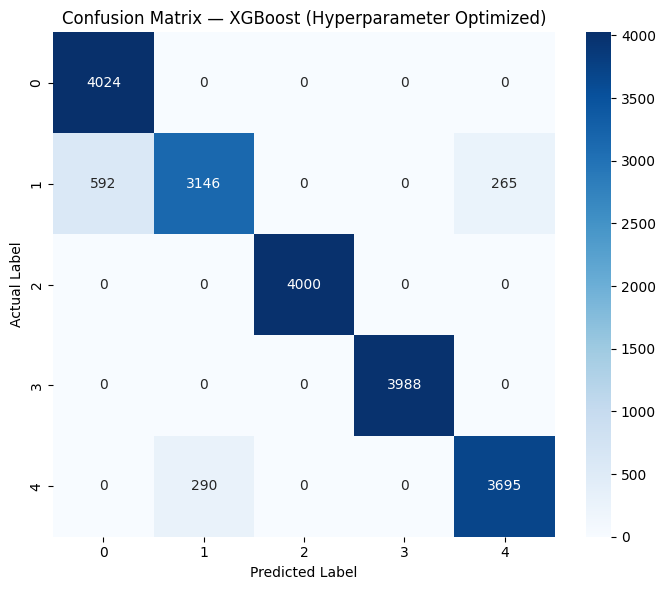


TP / FP / FN / TN per class (One-vs-Rest):

Binary Confusion Matrix (High Performer vs Others)
TP: 7683, FP: 265, FN: 290, TN: 11762


In [ ]:
print("\n==============================")
print("PIPELINE E — HYPERPARAMETER OPTIMIZATION (SAFE)")
print("==============================")

# 1) Feature-selected dataset
df_hp = df_fs.copy()
top_features_hp = top_features  # from Pipeline D
X_hp = df_hp[top_features_hp]
y_hp = df_hp["Performance_Label"]

# 2) Train/Test Split
X_train_hp, X_test_hp, y_train_hp, y_test_hp = train_test_split(
    X_hp, y_hp, test_size=0.2, random_state=42, stratify=y_hp
)

# 3) Scaling
scaler_hp = StandardScaler()
X_train_hp_scaled = scaler_hp.fit_transform(X_train_hp)
X_test_hp_scaled = scaler_hp.transform(X_test_hp)

# 4) Define hyperparameter grid manually
n_estimators_list = [50, 100]
max_depth_list = [3, 5]
learning_rate_list = [0.1]
subsample_list = [0.8, 1.0]

best_acc = 0
best_params = {}

# 5) Manual CV loop (3-fold stratified)
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for subsample in subsample_list:
                fold_acc = []
                for train_idx, val_idx in skf.split(X_train_hp_scaled, y_train_hp):
                    X_tr, X_val = X_train_hp_scaled[train_idx], X_train_hp_scaled[val_idx]
                    y_tr, y_val = y_train_hp.iloc[train_idx], y_train_hp.iloc[val_idx]

                    model = XGBClassifier(
                        objective="multi:softmax",
                        num_class=5,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        eval_metric="mlogloss",
                        tree_method="hist",
                        use_label_encoder=False,
                        random_state=42
                    )
                    model.fit(X_tr, y_tr)
                    y_pred = model.predict(X_val)
                    fold_acc.append(accuracy_score(y_val, y_pred))

                mean_acc = np.mean(fold_acc)
                if mean_acc > best_acc:
                    best_acc = mean_acc
                    best_params = {
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "learning_rate": learning_rate,
                        "subsample": subsample
                    }

print("\nBest Hyperparameters (manual search):", best_params)
print(f"Best CV Accuracy: {best_acc:.4f}")

# 6) Retrain on full training set
best_xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"],
    eval_metric="mlogloss",
    tree_method="hist",
    use_label_encoder=False,
    random_state=42
)
best_xgb.fit(X_train_hp_scaled, y_train_hp)

# 7) Predictions & Evaluation
pred_hp = best_xgb.predict(X_test_hp_scaled)

print("\n--- HYPERPARAMETER OPTIMIZATION RESULTS ---")
print(f"Accuracy:  {accuracy_score(y_test_hp, pred_hp):.4f}")
print(f"Precision: {precision_score(y_test_hp, pred_hp, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_hp, pred_hp, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_hp, pred_hp, average='weighted', zero_division=0):.4f}")
print("\nClassification Report:\n", classification_report(y_test_hp, pred_hp, zero_division=0))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 8) Confusion Matrix
cm = confusion_matrix(y_test_hp, pred_hp)

print("\nConfusion Matrix (Raw Counts):")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=sorted(y_hp.unique()),
    yticklabels=sorted(y_hp.unique())
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix — XGBoost (Hyperparameter Optimized)")
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

cm = confusion_matrix(y_test_hp, pred_hp)
labels = sorted(y_hp.unique())

results = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    results.append({
        "Class": label,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "TN": TN
    })

tpfn_table = pd.DataFrame(results)
print("\nTP / FP / FN / TN per class (One-vs-Rest):")
tpfn_table

# Convert to binary
y_test_bin = (y_test_hp >= 3).astype(int)
pred_bin = (pred_hp >= 3).astype(int)

cm_bin = confusion_matrix(y_test_bin, pred_bin)
TN, FP, FN, TP = cm_bin.ravel()

print("\nBinary Confusion Matrix (High Performer vs Others)")
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")



PIPELINE E — ROC & AUC EVALUATION


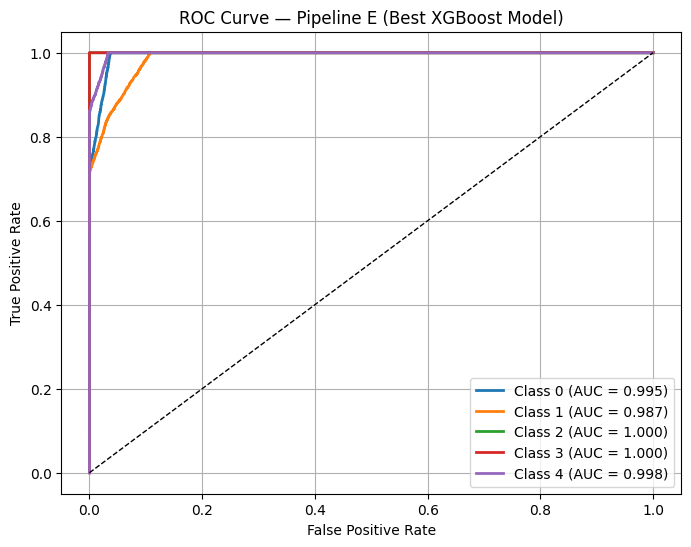


--- AUC SCORES (Pipeline E) ---
Class 0: AUC = 0.9946
Class 1: AUC = 0.9869
Class 2: AUC = 1.0000
Class 3: AUC = 1.0000
Class 4: AUC = 0.9976


In [ ]:
print("\n==============================")
print("PIPELINE E — ROC & AUC EVALUATION")
print("==============================")

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) Binarize labels for multi-class ROC
classes = np.unique(y_test_hp)
y_test_binary = label_binarize(y_test_hp, classes=classes)

# 2) Get probability predictions
y_proba = best_xgb.predict_proba(X_test_hp_scaled)

# Container for ROC curves
fpr = {}
tpr = {}
roc_auc = {}

# 3) Compute ROC curve + AUC for each class
for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_binary[:, i], y_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

# 4) Plot ROC curves
plt.figure(figsize=(8, 6))

for cls in classes:
    plt.plot(fpr[cls], tpr[cls], lw=2, label=f"Class {cls} (AUC = {roc_auc[cls]:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Pipeline E (Best XGBoost Model)")
plt.legend()
plt.grid(True)
plt.show()

# 5) Print AUC summary
print("\n--- AUC SCORES (Pipeline E) ---")
for cls in classes:
    print(f"Class {cls}: AUC = {roc_auc[cls]:.4f}")


--- PIPELINE E: EVALUATION METRICS ---
Accuracy:  0.9426
Precision: 0.9440
Recall:    0.9426
F1 Score:  0.9414

Classification Report (Text Labels):
               precision    recall  f1-score   support

Above Average       1.00      1.00      1.00      3988
      Average       1.00      1.00      1.00      4000
Below Average       0.92      0.79      0.85      4003
         High       0.93      0.93      0.93      3985
          Low       0.87      1.00      0.93      4024

     accuracy                           0.94     20000
    macro avg       0.94      0.94      0.94     20000
 weighted avg       0.94      0.94      0.94     20000



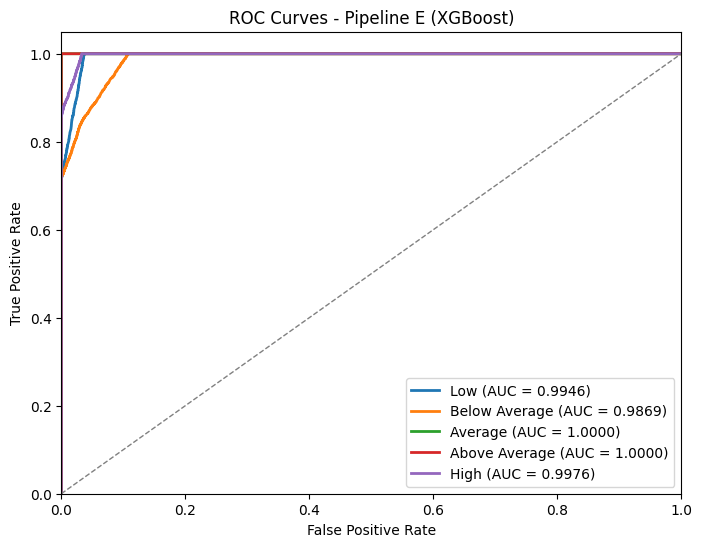

In [ ]:
# ======================================
# PIPELINE E — Model Evaluation with ROC & AUC (Text Labels)
# ======================================

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report

# 1) Define class label mapping
label_map = {
    0: "Low",
    1: "Below Average",
    2: "Average",
    3: "Above Average",
    4: "High"
}

# 2) Predict class
pred_hp = best_xgb.predict(X_test_hp_scaled)

# 3) Print evaluation metrics
print("\n--- PIPELINE E: EVALUATION METRICS ---")
print(f"Accuracy:  {accuracy_score(y_test_hp, pred_hp):.4f}")
print(f"Precision: {precision_score(y_test_hp, pred_hp, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_hp, pred_hp, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_hp, pred_hp, average='weighted', zero_division=0):.4f}")
print("\nClassification Report (Text Labels):")
print(classification_report(
    y_test_hp.map(label_map),
    pd.Series(pred_hp).map(label_map),
    zero_division=0
))

# 4) Binarize labels for ROC/AUC
y_test_binarized = label_binarize(y_test_hp, classes=[0,1,2,3,4])
y_proba = best_xgb.predict_proba(X_test_hp_scaled)

# 5) Plot ROC curves
plt.figure(figsize=(8,6))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label_map[i]} (AUC = {roc_auc:.4f})")

plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Pipeline E (XGBoost)')
plt.legend(loc='lower right')
plt.show()

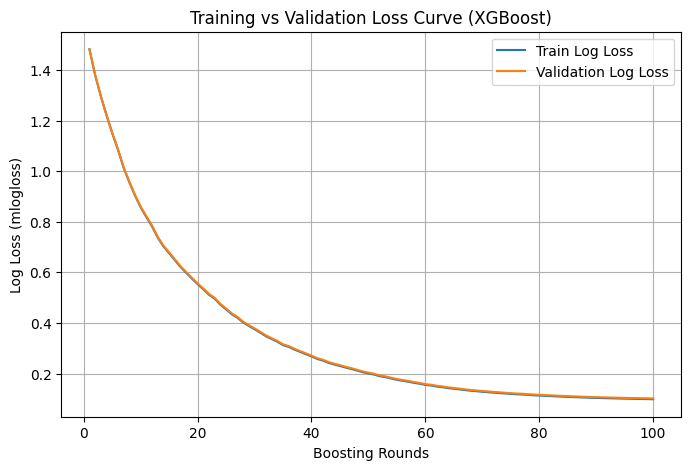

In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Train a fresh XGB model WITH eval_set (for plotting loss curves)
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    subsample=best_params["subsample"],
    eval_metric="mlogloss",      # <-- only here (not in .fit)
    use_label_encoder=False,
    tree_method="hist",
    random_state=42
)

# Provide train + validation set
eval_set = [
    (X_train_hp_scaled, y_train_hp),
    (X_test_hp_scaled, y_test_hp)
]

# Fit model and track evaluation history
xgb.fit(
    X_train_hp_scaled,
    y_train_hp,
    eval_set=eval_set,
    early_stopping_rounds=20,
    verbose=False
)

# Retrieve training history
evals_result = xgb.evals_result()

train_loss = evals_result['validation_0']['mlogloss']
val_loss   = evals_result['validation_1']['mlogloss']
rounds = range(1, len(train_loss) + 1)

# Plot training & validation loss curves
plt.figure(figsize=(8,5))
plt.plot(rounds, train_loss, label='Train Log Loss')
plt.plot(rounds, val_loss, label='Validation Log Loss')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss (mlogloss)")
plt.title("Training vs Validation Loss Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()